# Overview
The task is to identify sleep patterns given samples of accelerometer data. 

In [1]:
# Render our plots inline
%matplotlib inline

import numpy as np
import h5py
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
from pandas import HDFStore,DataFrame
import itertools
import math

In [2]:
def load_data(filename):
    path = '../data/labelled/'+ filename
    hf = h5py.File(path, 'r')

    reread = pd.read_hdf(path)
    data = reread#.head(10000)
    hf.close()
    return data

def load_csv(filename):
    data = pd.read_csv('../data/labelled/'+ filename)
    
    return data

def load_targets(subject_number):
    filename = '../data/labelled/ID'+str(subject_number)+'/PSG'+ str(subject_number) +'_targets.h5'
    hf = h5py.File(filename, 'r')

    reread = pd.read_hdf(filename)
    targets = reread#.head(10000)
    hf.close()
    return targets

def load_features(subject_number):
    filename = '../data/labelled/ID'+str(subject_number)+'/PSG'+ str(subject_number) +'_features.h5'
    hf = h5py.File(filename, 'r')

    reread = pd.read_hdf(filename)
    features = reread#.head(10000)
    hf.close()
    return features

In [3]:
def combine_data(subject_ids):
    
    data = []
    y = []
    
    
    for i in range(len(subject_ids)):
        
        features = load_features(subject_ids[i])
        targets = load_targets(subject_ids[i])
        
        data.append(features)
        y.append(targets)
    
    result_X = pd.concat(data)
    result_X = result_X.reset_index()
    result_X = result_X.drop(['index'], axis = 1)
    
    result_y = pd.concat(y)
    result_y = result_y.reset_index()
    result_y = result_y.drop(['index'], axis = 1)
    
    return result_X, result_y.values.ravel()

In [4]:
# subject_ids = [1,6,14,15,18,19,20,23,24,25,27,28,29,30,31,32,35,37,39]

unlabelled_ids =[6, 15, 19, 20, 24, 25, 27, 28, 30, 31, 32, 35]

train_ids =[1, 23, 29, 37, 39]

test_ids = [14, 18]

X_train, y_train = combine_data(train_ids)
X_test, y_test = combine_data(test_ids)
X_unl, y_unl = combine_data(unlabelled_ids)
extra_unl = load_data('Unlabelled_data.h5').values

In [5]:
unlabelled = np.concatenate([X_unl.copy().values, extra_unl.copy()])

In [6]:
unlabelled_data = pd.DataFrame(data=unlabelled)

# Model building and evaluation

In [10]:
from sklearn.cross_validation import train_test_split, cross_val_score
import sklearn.metrics as met
import seaborn as sn
import math
    
# helper function to quickly build different models
def model_build(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def plot_confusion_matrix(array):
    array = array
    x_labels = ['sleep', 'wake']
    y_labels = ['sleep', 'wake']
    df_cm = pd.DataFrame(array, y_labels,x_labels)
    plt.figure(figsize = (4,4))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", fmt='g')# font size
    plt.show()

# helper function to handle evaluation
def model_eval(model, X_test, y_test):
    pred = model.predict(X_test)
    print('Accuracy:\n-----------------------------')
    print(met.accuracy_score(y_test, pred))
    print('\nConfusion Matrix:\n-----------------------------')
    conf = met.confusion_matrix(y_test, pred)
    plot_confusion_matrix(conf)
    #print(met.confusion_matrix(y_test, pred))
    print('\nClassification Report:\n-----------------------------')
    print(met.classification_report(y_test, pred, digits= 5))
    
    TP = conf.tolist()[0][0]
    FN = conf.tolist()[0][1]
    FP = conf.tolist()[1][0]
    TN = conf.tolist()[1][1]
    sen = TP/(TP+FN)
    spe = TN/(TN+FP)
    gmean= math.sqrt(sen*spe)
    
    print('TP, FN, FP, TN: '+ str(TN)+', '+ str(FP)+', '+str(FN)+', '+str(TP))
    print('Sensitivity:' + str(sen))
    print('Specificity:' + str(spe))
    print('G-mean:'+ str(gmean))

In [11]:
from sklearn.metrics import accuracy_score

#The co-Training Multiview method.
def coMultiview(X_train, y_train, unlabelled_data, classifier):
    
    print('Unlabelled data left: ' +str(len(unlabelled_data)))
    
    k = 0.001
    
    #check if classifier input is valid
    if classifier == "rf" or classifier == 'dt' or classifier == 'xgb':
        #While instances left in unlabelled update labelled and unlabelled data sets.
        while len(unlabelled_data)>0:
            X_train, y_train, unlabelled_data, k = add_unlabelled(X_train, y_train, unlabelled_data, classifier, k)
        
        return X_train.values, y_train
    
    else:
        print('No classifier called '+ classifier +'. Classifier has to be "rf", "xgb", or "dt".')
        return X_train.values, y_train
    

#This method removed the instances from the unlabelled data set with a prediction confidence above a set threshold and 
# adds them to the labelled data set. 
def add_unlabelled(X_train, y_train, unlabelled_data, classifier, k):
    
    length = len(unlabelled_data.index)
    
    #Gets the prediction confidences for the unlabelled data
    confidences = get_confidences(X_train, y_train, unlabelled_data, classifier)
    
    #Finds the instances with high enough prediction confidences
    highest_conf_X, highest_conf_y, unlabelled_data = get_most_confident(confidences, unlabelled_data, k)
    
    #Add the most confident instances from unlabelled to the labelled data
    df = pd.DataFrame(data = highest_conf_X, columns = X_train.columns)
    X_train = pd.concat([X_train, df])
    y_train = np.concatenate([y_train, highest_conf_y])
    
    #Update k value
    if(length - len(unlabelled_data.index) < 1000) and k<0.64:
        k = k*2
    
    print('Unlabelled data left: '+str(len(unlabelled_data)))
        
    return X_train, y_train, unlabelled_data, k
        

#This method trains two of the specified classifier on the two separate views, calculates the prediction confidences
# for all instances in unlabelled for both classifiers, multiplies the confidences for each classifier together and
# returns it as one list of confidences.    
def get_confidences(X_train, y_train, unlabelled, classifier):
    
    #get the specific vies for labelled and unlabelled data
    X_train_b, unlabelled_b = get_back_view(X_train, unlabelled)
    X_train_t, unlabelled_t = get_thigh_view(X_train, unlabelled)
    
    #trains the specified classifiers on the two different views
    models = []
    if classifier == 'rf':
        models.append(model_build(RandomForestClassifier(n_estimators=20), X_train_b, y_train.ravel()))
        models.append(model_build(RandomForestClassifier(n_estimators=20), X_train_t, y_train.ravel()))
    if classifier == 'xgb':
        models.append(model_build(XGBClassifier(n_estimators=150), X_train_b, y_train.ravel()))
        models.append(model_build(XGBClassifier(n_estimators=150), X_train_t, y_train.ravel()))
    if classifier == 'dt':
        models.append(model_build(DecisionTreeClassifier(), X_train_b, y_train.ravel()))
        models.append(model_build(DecisionTreeClassifier(), X_train_t, y_train.ravel()))
    
    #combines the prediction confidences into one by multiplying them together.
    confs1 = models[0].predict_proba(unlabelled_b)
    confs2 = models[1].predict_proba(unlabelled_t)
        
    confidences = np.multiply(confs1, confs2)
    
    return confidences


#This method returns the instances in unlabelled with predictions over a set threshold and removed them from the unlabelled data
#set. The updated unlabelled data set is also returned.
def get_most_confident(confidences, unlabelled_data, k):
    
    #sets the threshold
    highest_value = np.amax(confidences)
    length = len(unlabelled_data)
    
    threshold = highest_value - k
    
    #List containing the instances with highest prediction confidences
    highest_conf_X = []
    highest_conf_y = []
    
    #list of unlabelled data indices
    indices = unlabelled_data.index.tolist()
    
    #List of row values/instances in unlabelled data
    instances = unlabelled_data.copy().values
    
    i = 0
    for instance in instances:
        conf = confidences[i]
        
        sleep_conf = conf[0]
        wake_conf = conf[1]
        
        #Checks which prediction is the most confident and if it is above threshold add the instance to labelled
        # and removed from unlabelled
        if (sleep_conf >= wake_conf) and sleep_conf>threshold:
            highest_conf_y.append(1)
            highest_conf_X.append(instance)
            
            unlabelled_data = unlabelled_data.drop([indices[i]])
        elif (wake_conf > sleep_conf) and wake_conf>threshold:
            highest_conf_y.append(2)
            highest_conf_X.append(instance)
            
            unlabelled_data = unlabelled_data.drop([indices[i]])
            
        i = i + 1


    return highest_conf_X, highest_conf_y, unlabelled_data

#Function for getting the back view feature set
def get_back_view(X_train, unlabelled):
    num_features = (len(X_train.columns)-2)/7
    b_limit = int(num_features*3)+1
    
    X_train_b = X_train.iloc[:, :b_limit].copy()
    unlabelled_b = unlabelled.iloc[:, :b_limit].copy()
    
    return X_train_b.values, unlabelled_b.values

#Function for getting the thigh view feature set
def get_thigh_view(X_train, unlabelled):
    num_features = (len(X_train.columns)-2)/7
    b_limit = int(num_features*3)+1
    t_limit = int(num_features*6)+2
    
    X_train_t = X_train.iloc[:, b_limit:t_limit].copy()
    unlabelled_t = unlabelled.iloc[:, b_limit:t_limit].copy()
    
    return X_train_t.values, unlabelled_t.values


# Training and results -DT

In [12]:
from sklearn.tree import DecisionTreeClassifier

#Decision Tree
X_dt, y_dt = coMultiview(X_train, y_train, unlabelled_data, 'dt')

Accuracy:
-----------------------------
0.7822111388196176

Confusion Matrix:
-----------------------------


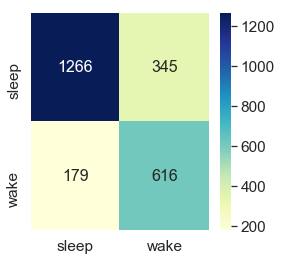


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.87612   0.78585   0.82853      1611
          2    0.64100   0.77484   0.70159       795

avg / total    0.79843   0.78221   0.78659      2406

TP, FN, FP, TN: 616, 179, 345, 1266
Sensitivity:0.7858472998137802
Specificity:0.7748427672955975
G-mean:0.7803256348855153


In [13]:
dtc = model_build(DecisionTreeClassifier(), X_dt, y_dt)
model_eval(dtc, X_test, y_test)

C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Accuracy:
-----------------------------
0.8994181213632585

Confusion Matrix:
-----------------------------


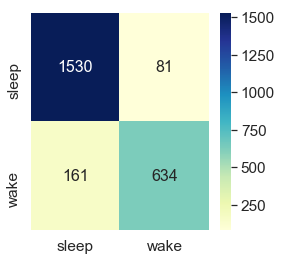


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.90479   0.94972   0.92671      1611
          2    0.88671   0.79748   0.83974       795

avg / total    0.89882   0.89942   0.89797      2406

TP, FN, FP, TN: 634, 161, 81, 1530
Sensitivity:0.9497206703910615
Specificity:0.7974842767295598
G-mean:0.8702800135140002


In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_dtc = model_build(RandomForestClassifier(n_estimators=20), X_dt, y_dt)
model_eval(rf_dtc, X_test, y_test)

Accuracy:
-----------------------------
0.9110556940980881

Confusion Matrix:
-----------------------------


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


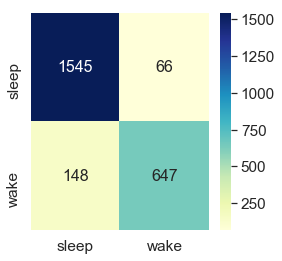


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.91258   0.95903   0.93523      1611
          2    0.90743   0.81384   0.85809       795

avg / total    0.91088   0.91106   0.90974      2406

TP, FN, FP, TN: 647, 148, 66, 1545
Sensitivity:0.9590316573556797
Specificity:0.8138364779874214
G-mean:0.8834562503603594


In [15]:
from xgboost import XGBClassifier

xgb_dtc = model_build(XGBClassifier(n_estimators=150), X_dt.values, y_dt.ravel())
model_eval(xgb_dtc, X_test.values, y_test.ravel())

In [16]:
#Save data

#X = pd.DataFrame(X_dt)
#y = pd.DataFrame(y_dt)
#X.to_hdf('X_train_comv_dt_0.h5', key = 'xtraincomv')
#y.to_hdf('y_train_comv_dt_0.h5', key = 'ytraincomv')

C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


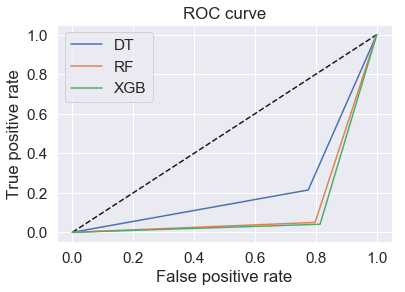

In [17]:
pred_dt = dtc.predict(X_test)
fpr_dt, tpr_dt, thresholds_dt = met.roc_curve(y_test, pred_dt, pos_label=1)

pred_rf = rf_dtc.predict(X_test)
fpr_rf, tpr_rf, thresholds_rf = met.roc_curve(y_test, pred_rf, pos_label=1)

pred_xgb = xgb_dtc.predict(X_test.values)
fpr_xgb, tpr_xgb, thresholds_dt = met.roc_curve(y_test, pred_xgb, pos_label=1)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dt, tpr_dt, label='DT')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_xgb, tpr_xgb, label='XGB')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Training and results - RF

In [18]:

#Random Forest
X_rf, y_rf = coMultiview(X_train, y_train, unlabelled_data, 'rf')

Accuracy:
-----------------------------
0.9010806317539485

Confusion Matrix:
-----------------------------


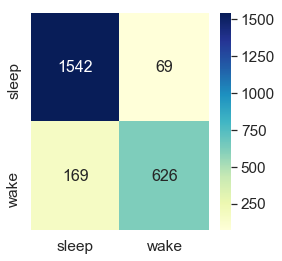


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.90123   0.95717   0.92836      1611
          2    0.90072   0.78742   0.84027       795

avg / total    0.90106   0.90108   0.89925      2406

TP, FN, FP, TN: 626, 169, 69, 1542
Sensitivity:0.957169459962756
Specificity:0.7874213836477988
G-mean:0.8681564954253869


In [19]:
rfc = model_build(RandomForestClassifier(n_estimators=20), X_rf, y_rf)
model_eval(rfc, X_test, y_test)

Accuracy:
-----------------------------
0.7942643391521197

Confusion Matrix:
-----------------------------


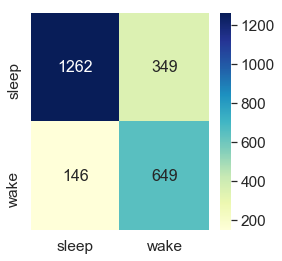


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.89631   0.78336   0.83604      1611
          2    0.65030   0.81635   0.72393       795

avg / total    0.81502   0.79426   0.79899      2406

TP, FN, FP, TN: 649, 146, 349, 1262
Sensitivity:0.7833643699565487
Specificity:0.8163522012578617
G-mean:0.7996882066161827


In [20]:
dt_rfc = model_build(DecisionTreeClassifier(), X_rf, y_rf)
model_eval(dt_rfc, X_test, y_test)

Accuracy:
-----------------------------
0.8969243557772236

Confusion Matrix:
-----------------------------


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


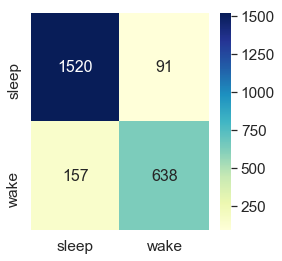


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.90638   0.94351   0.92457      1611
          2    0.87517   0.80252   0.83727       795

avg / total    0.89607   0.89692   0.89573      2406

TP, FN, FP, TN: 638, 157, 91, 1520
Sensitivity:0.9435133457479826
Specificity:0.8025157232704403
G-mean:0.870163372636573


In [21]:
xgb_rfc = model_build(XGBClassifier(n_estimators=150), X_rf.values, y_rf.ravel())
model_eval(xgb_rfc, X_test.values, y_test.ravel())

In [22]:
# Save data

#X = pd.DataFrame(X_rf)
#y = pd.DataFrame(y_rf)
#X.to_hdf('X_train_comv_rf_0.h5', key = 'xtraincomv')
#y.to_hdf('y_train_comv_rf_0.h5', key = 'ytraincomv')

C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


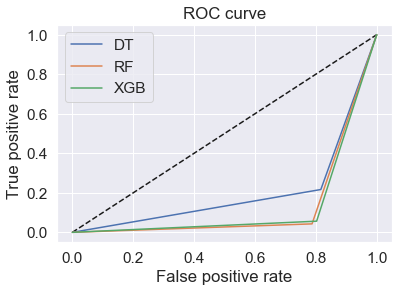

In [23]:
pred_dt = dt_rfc.predict(X_test)
fpr_dt, tpr_dt, thresholds_dt = met.roc_curve(y_test, pred_dt, pos_label=1)

pred_rf = rfc.predict(X_test)
fpr_rf, tpr_rf, thresholds_rf = met.roc_curve(y_test, pred_rf, pos_label=1)

pred_xgb = xgb_rfc.predict(X_test.values)
fpr_xgb, tpr_xgb, thresholds_dt = met.roc_curve(y_test, pred_xgb, pos_label=1)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dt, tpr_dt, label='DT')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_xgb, tpr_xgb, label='XGB')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Training and results - XGB

In [24]:
#XGBoost
X_xgb, y_xgb = coMultiview(X_train, y_train, unlabelled_data, 'xgb')

Accuracy:
-----------------------------
0.9139650872817955

Confusion Matrix:
-----------------------------


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


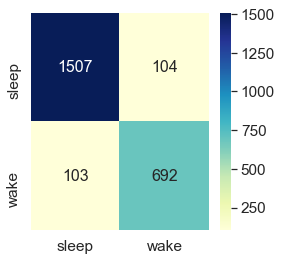


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.93602   0.93544   0.93573      1611
          2    0.86935   0.87044   0.86989       795

avg / total    0.91399   0.91397   0.91398      2406

TP, FN, FP, TN: 692, 103, 104, 1507
Sensitivity:0.9354438237119801
Specificity:0.8704402515723271
G-mean:0.9023568901735253


In [26]:
xgbc = model_build(XGBClassifier(n_estimators=150), X_xgb.values, y_xgb.ravel())
model_eval(xgbc, X_test.values, y_test.ravel())

Accuracy:
-----------------------------
0.8229426433915212

Confusion Matrix:
-----------------------------


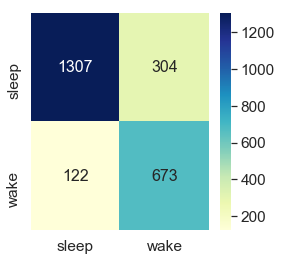


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.91463   0.81130   0.85987      1611
          2    0.68884   0.84654   0.75959       795

avg / total    0.84002   0.82294   0.82674      2406

TP, FN, FP, TN: 673, 122, 304, 1307
Sensitivity:0.8112973308504035
Specificity:0.8465408805031447
G-mean:0.8287317761543548


In [27]:
dt_xgbc = model_build(DecisionTreeClassifier(), X_xgb, y_xgb)
model_eval(dt_xgbc, X_test, y_test)

Accuracy:
-----------------------------
0.9123025768911056

Confusion Matrix:
-----------------------------


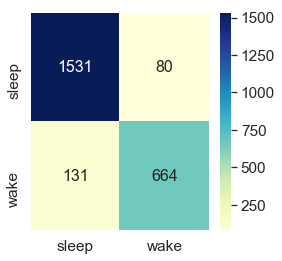


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.92118   0.95034   0.93553      1611
          2    0.89247   0.83522   0.86290       795

avg / total    0.91169   0.91230   0.91153      2406

TP, FN, FP, TN: 664, 131, 80, 1531
Sensitivity:0.9503414028553694
Specificity:0.8352201257861636
G-mean:0.8909232660743914


In [28]:
rf_xgbc = model_build(RandomForestClassifier(n_estimators=20), X_xgb, y_xgb)
model_eval(rf_xgbc, X_test, y_test)

In [29]:
#X = pd.DataFrame(X_xgb)
#y = pd.DataFrame(y_xgb)
#X.to_hdf('X_train_comv_xgb_0.h5', key = 'xtraincomv')
#y.to_hdf('y_train_comv_xgb_0.h5', key = 'ytraincomv')

C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


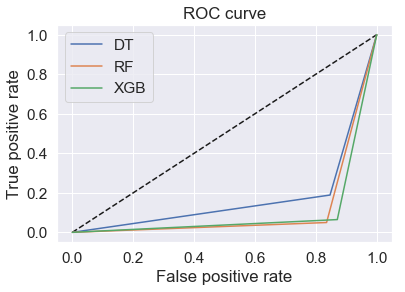

In [30]:
pred_dt = dt_xgbc.predict(X_test)
fpr_dt, tpr_dt, thresholds_dt = met.roc_curve(y_test, pred_dt, pos_label=1)

pred_rf = rf_xgbc.predict(X_test)
fpr_rf, tpr_rf, thresholds_rf = met.roc_curve(y_test, pred_rf, pos_label=1)

pred_xgb = xgbc.predict(X_test.values)
fpr_xgb, tpr_xgb, thresholds_dt = met.roc_curve(y_test, pred_xgb, pos_label=1)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dt, tpr_dt, label='DT')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_xgb, tpr_xgb, label='XGB')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()